# **DATA AUGMENTATION**

###**1. Import libraries**

In [ ]:
import os
import time
import cv2
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from imgaug import augmenters as iaa
import albumentations as A

###**2. Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**3. Define paths**

In [ ]:
image_path = '/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/original/Flickr-dog'
num_of_categories = 42

In [ ]:
breed_list = sorted(os.listdir(image_path))

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

42 breeds


In [ ]:
#check number of files should be the same
!find /content/drive/MyDrive/Project\ FindPet/dataset/FlickrDogDataset/dataAug -type f | wc -l
!find /content/drive/MyDrive/Project\ FindPet/dataset/FlickrDogDataset/original/Flickr-dog -type f | wc -l

374
374


In [ ]:
path_train='/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/dataAug/train/'
breed_list = os.listdir(path_train)


###**3. Define custom augmentation**

In [ ]:
def augmentImages(path_ds_train):
  #Define augmentation Pipeline
  augmentation_pipeline = A.Compose(
      [
          A.RandomRotate90(),
          A.Flip(),
          A.Transpose(),
          A.OneOf([
              A.IAAAdditiveGaussianNoise(),
              A.GaussNoise(),
          ], p=0.2),
          A.OneOf([
              A.MotionBlur(p=.2),
              A.MedianBlur(blur_limit=3, p=0.1),
              A.Blur(blur_limit=3, p=0.1),
          ], p=0.2),
          A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
          A.OneOf([
              A.OpticalDistortion(p=0.3),
              A.GridDistortion(p=.1),
              A.IAAPiecewiseAffine(p=0.3),
          ], p=0.2),
          A.OneOf([
              A.CLAHE(clip_limit=2),
              A.IAASharpen(),
              A.IAAEmboss(),
              A.RandomBrightnessContrast(),            
          ], p=0.3),
          A.HueSaturationValue(p=0.3),
      ]
  )
  breed_list = os.listdir(path_ds_train)
  for breed in breed_list:
        base_name = path_ds_train + breed + '/'
        for idx, img_name in enumerate(os.listdir(base_name)):
            img_path = base_name + img_name
            image = imageio.imread(img_path)
            #generate 10 tranformations per image
            for i in range(10):
              transformed_image = augmentation_pipeline(image = image)['image']
              img_aug_path = base_name + img_name.split('-')[0]+'-aug-'+str(i).zfill(4) + '.' + img_name.split('.')[1]
              imageio.imwrite(img_aug_path, transformed_image)
              #print(img_aug_path)

In [ ]:
augmentImages(path_train)

In [ ]:
#check number of files after data augmentation
!find /content/drive/MyDrive/Project\ FindPet/dataset/FlickrDogDataset/dataAug -type f | wc -l
!find /content/drive/MyDrive/Project\ FindPet/dataset/FlickrDogDataset/original/Flickr-dog -type f | wc -l

2574
374


## **Test Data Augmentation Libraries**

###**ImgAug Library**

In [ ]:
#Define image path
path = '/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/original/Flickr-dog/Apolo/Apolo__01-crp.png'

In [ ]:
#Read image
image = imageio.imread(path)

In [ ]:
#Define tranformations
flipr = iaa.Fliplr(1) #Horizontally flip
flipud = iaa.Flipud(1) #Vertically flip
affine= iaa.Affine(
  scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, #Scale images to a value of 80 to 120% of their original size, but do this independently per axis
  translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, #Translate images by -20 to 20 % on x- and y-axis independently
  rotate=(-40, 40), #Rotate images by -40 to 40 degrees
  shear=(-8, 8) #Shear images by -8 to 8 degrees
)
gaus = iaa.GaussianBlur(sigma=(0.0, 3.0))# apply Gaussian blur with a sigma between 0 and 3

In [ ]:
# get augmented images
image_flipr = flipr.augment_images([image])
image_flipud = flipud.augment_images([image])
image_affined = affine.augment_images([image])
image_gaus = gaus.augment_images([image])

In [ ]:
images_aug = [image_flipr[0], image_flipud[0], image_affined[0], image_gaus[0]]

Text(0.5, 1.0, 'Sample augmentations')

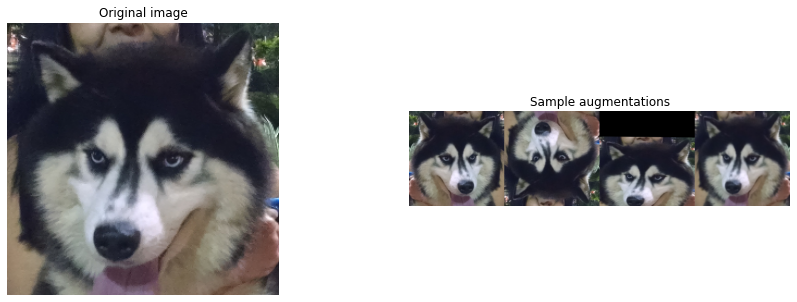

In [ ]:
#Plot original image and augmentations
plt.figure(figsize=(15,5))
#plot original example
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Original image')
plt.imshow(image)
# plot augmentation examples
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.title('Sample augmentations')

In [ ]:
#Define augmentation pipeline
aug_pipeline = iaa.Sequential([
                iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))),
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
images_aug = np.array([aug_pipeline.augment_image(image) for _ in range(16)])
print(images_aug.shape)

(16, 250, 250, 3)


In [ ]:
def gallery(array, ncols=3):
    '''
    Function to arange images into a grid.
    INPUT:
        array - numpy array containing images
        ncols - number of columns in resulting imahe grid
    OUTPUT:
        result - reshaped array into a grid with given number of columns
    '''
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

Text(0.5, 1.0, 'Augmentation pipeline examples')

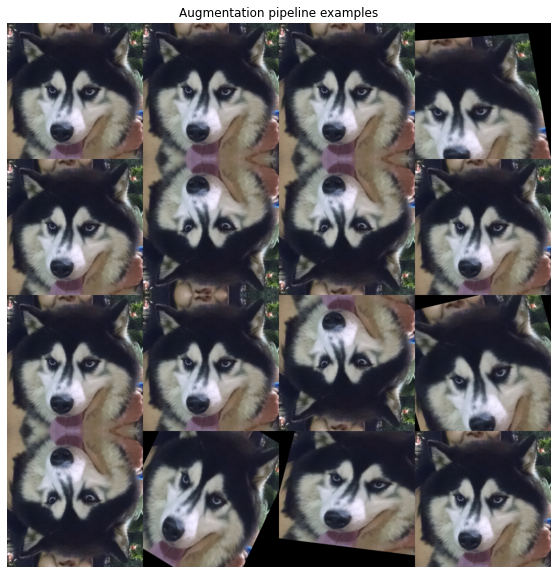

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')

In [ ]:
#Define different augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))), # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # apply one of the augmentations: Dropout or CoarseDropout
    iaa.OneOf([
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ])
],
random_order=True # apply the augmentations in random order
)

# apply augmentation pipeline to sample image
images_aug = np.array([aug_pipeline.augment_image(image) for _ in range(16)])

Text(0.5, 1.0, 'Augmentation pipeline examples')

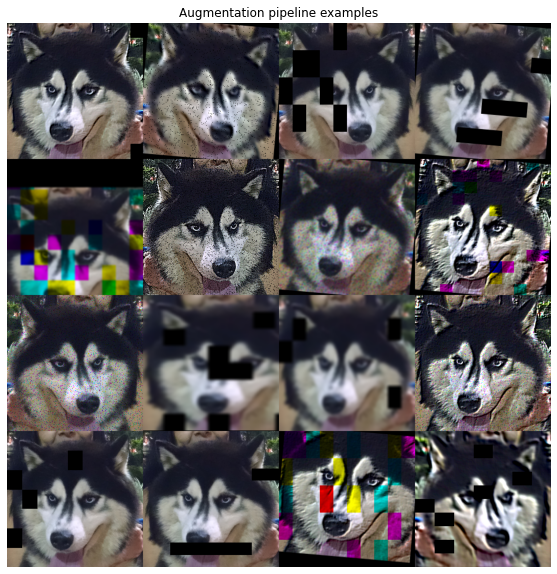

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')

###**Albumentation Library**

In [ ]:
import albumentations as A

In [ ]:
image = imageio.imread(path)

In [ ]:
#Define albumentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.RandomRotate90(), #Randomly rotate the input by 90 degrees zero or more times
        A.Flip(), #Flip the image either horizontally, vertically or both horizontally and vertically
        A.Transpose(), #Transpose the input image by swapping rows and columns
        # apply one of the augmentations: IAAAdditiveGaussianNoise or GaussNoise
        A.OneOf([ 
            A.IAAAdditiveGaussianNoise(), #Add gaussian noise to the input image
            A.GaussNoise(), #Apply gaussian noise to the input image
        ], p=0.2), #Apply 20% of images
        # apply one of the augmentations
        A.OneOf([
            A.MotionBlur(p=.2), #Apply motion blur to the input image using a random-sized kernel
            A.MedianBlur(blur_limit=3, p=0.1), # Blur the input image using a median filter with a random aperture linear size
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        # apply one of the augmentations to 20% of images
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        # apply one of the augmentations to 30% of images
        A.OneOf([
            A.CLAHE(clip_limit=2), #Apply Contrast Limited Adaptive Histogram Equalization to the input image
            A.IAASharpen(), #Sharpen the input image and overlays the result with the original image
            A.IAAEmboss(), #Emboss the input image and overlays the result with the original image
            A.RandomBrightnessContrast(), #Randomly change brightness and contrast of the input image       
        ], p=0.3),
        A.HueSaturationValue(p=0.3), #Randomly change hue, saturation and value of the input image
    ]
)

Text(0.5, 1.0, 'Augmentation pipeline examples')

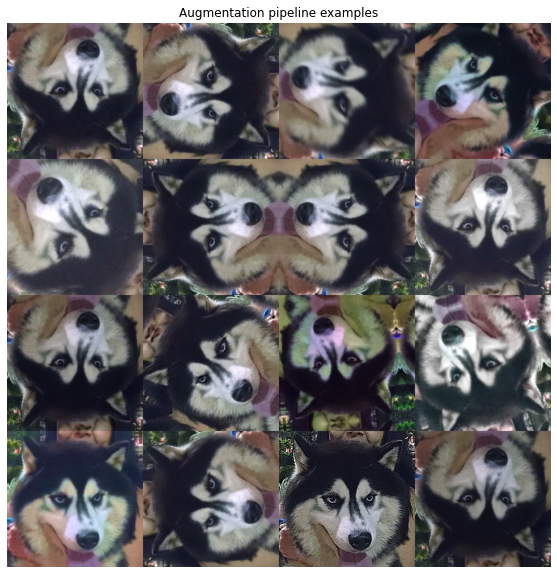

In [ ]:
# apply pipeline to sample image
images_aug = np.array([augmentation_pipeline(image = image)['image'] for _ in range(16)])

# visualize augmentation results
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')